In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score



データ読み取り

In [14]:
df=pd.read_csv('../../data/learning_data.csv',index_col=0)

X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=42)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [15]:
class DNN_12(nn.Module):
    def __init__(self, input_dim,dropout1,dropout2):
        super(DNN_12, self).__init__()
        self.layer1 = nn.Linear(input_dim,64)
        self.layer2 = nn.Linear(64,32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16, 8)
        self.output_layer = nn.Linear(8, 1)

        self.dropout1 = nn.Dropout(dropout1)
        self.dropout2 = nn.Dropout(dropout2)
        
        
    def forward(self, x):
        x = torch.relu(self.layer1(x))
    
        
        x = torch.relu(self.layer2(x))
        x = self.dropout1(x)

        x = torch.relu(self.layer3(x))
        

        x = torch.relu(self.layer4(x))
        x = self.dropout2(x)

        x = torch.sigmoid(self.output_layer(x)) 
        return x
    

学習データセットの作成

In [16]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=4, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=4, shuffle=False)

Optunaの設定

In [17]:
def objective(trial):
    dropout1 = trial.suggest_float("dropout1", 0, 0.5, step=0.05)
    dropout2 = trial.suggest_float("dropout2", 0, 0.5, step=0.05)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整

    # モデル定義
    model = DNN_12(
        input_dim=X_train_tensor.shape[1],
        dropout1=dropout1,
        dropout2=dropout2
    ).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Early Stoppingの設定
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    # 訓練ループ
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch.squeeze())
            loss.backward()
            optimizer.step()

        # バリデーション評価
        model.eval()
        val_loss = 0
        val_true, val_pred = [], []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss += criterion(val_outputs, y_val.squeeze()).item()
                predictions = (val_outputs >0.49).float()
                val_true.extend(y_val.cpu().numpy())
                val_pred.extend(predictions.cpu().numpy())

        val_loss /= len(val_loader)

        # Early Stoppingの判定
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Optunaへのログ
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # 評価指標の計算
    mcc = matthews_corrcoef(val_true, val_pred)
    print(f"Final MCC: {mcc:.4f}")

    return mcc  # mccを返す


In [18]:
device_id = 0  # 使用するGPUのID（0または1）
torch.cuda.set_device(device_id)
device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")

# Optunaの設定
study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=100)

# 結果表示
print("Best Parameters: ", study.best_params)
print("Best Validation F1: ", study.best_value)

[I 2024-12-04 16:17:11,487] A new study created in memory with name: no-name-42aceec1-6277-4f84-93e7-f8b13d943534
/tmp/ipykernel_282960/730803207.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282960/730803207.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:17:51,552] Trial 0 finished with value: 0.23524581800529842 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.1, 'learning_rate': 0.0017772270148801786, 'weight_decay': 6.715699614123207e-05}. Best is trial 0

Early stopping at epoch 12
Final MCC: 0.2352


/tmp/ipykernel_282960/730803207.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282960/730803207.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:18:41,531] Trial 1 finished with value: 0.0 and parameters: {'dropout1': 0.05, 'dropout2': 0.4, 'learning_rate': 0.007411562596050715, 'weight_decay': 0.004102866106875619}. Best is trial 0 with value: 0.23524581800529842.


Early stopping at epoch 14
Final MCC: 0.0000


/tmp/ipykernel_282960/730803207.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282960/730803207.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:19:38,364] Trial 2 finished with value: 0.3444571811508554 and parameters: {'dropout1': 0.1, 'dropout2': 0.2, 'learning_rate': 0.0027570403433554783, 'weight_decay': 2.9040923429646158e-05}. Best is trial 2 with value: 0.3444571811508554.


Early stopping at epoch 16
Final MCC: 0.3445


/tmp/ipykernel_282960/730803207.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282960/730803207.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:20:22,036] Trial 3 finished with value: 0.3281671969310326 and parameters: {'dropout1': 0.4, 'dropout2': 0.15000000000000002, 'learning_rate': 0.002552726715615874, 'weight_decay': 0.00019122633296030512}. Best is trial 2 with value: 0.3444571811508554.


Early stopping at epoch 12
Final MCC: 0.3282


/tmp/ipykernel_282960/730803207.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282960/730803207.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:22:10,207] Trial 4 finished with value: 0.30848104683740524 and parameters: {'dropout1': 0.4, 'dropout2': 0.15000000000000002, 'learning_rate': 0.00019227390071489936, 'weight_decay': 0.00016329681302709793}. Best is trial 2 with value: 0.3444571811508554.


Early stopping at epoch 31
Final MCC: 0.3085


/tmp/ipykernel_282960/730803207.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282960/730803207.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:23:43,624] Trial 5 finished with value: 0.37847948497224676 and parameters: {'dropout1': 0.2, 'dropout2': 0.25, 'learning_rate': 0.00026531981979558686, 'weight_decay': 0.00044058555855240676}. Best is trial 5 with value: 0.37847948497224676.


Early stopping at epoch 27
Final MCC: 0.3785


/tmp/ipykernel_282960/730803207.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282960/730803207.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:24:41,070] Trial 6 finished with value: 0.0 and parameters: {'dropout1': 0.05, 'dropout2': 0.05, 'learning_rate': 0.0032849317072902425, 'weight_decay': 0.00936035870647688}. Best is trial 5 with value: 0.37847948497224676.


Early stopping at epoch 16
Final MCC: 0.0000


/tmp/ipykernel_282960/730803207.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282960/730803207.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:24:44,398] Trial 7 pruned. 
[I 2024-12-04 16:26:17,774] Trial 8 finished with value: 0.0 and parameters: {'dropout1': 0.45, 'dropout2': 0.45, 'learning_rate': 0.0006674959358811906, 'weight_decay': 0.006245249957530613}. Best is trial 5 with value: 0.37847948497224676.


Early stopping at epoch 26
Final MCC: 0.0000


/tmp/ipykernel_282960/730803207.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282960/730803207.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:26:21,190] Trial 9 pruned. 
[I 2024-12-04 16:28:32,680] Trial 10 finished with value: 0.33706018014315553 and parameters: {'dropout1': 0.2, 'dropout2': 0.30000000000000004, 'learning_rate': 0.00011661585336846837, 'weight_decay': 0.0010516634735335086}. Best is trial 5 with value: 0.37847948497224676.


Early stopping at epoch 38
Final MCC: 0.3371


/tmp/ipykernel_282960/730803207.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282960/730803207.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:28:36,103] Trial 11 pruned. 
[I 2024-12-04 16:28:39,507] Trial 12 pruned. 
[I 2024-12-04 16:28:42,936] Trial 13 pruned. 
[I 2024-12-04 16:28:46,287] Trial 14 pruned. 
[I 2024-12-04 16:30:21,869] Trial 15 finished with value: 0.0 and parameters: {'dropout1': 0.1, 'dropout2': 0.5, 'learning_rate': 0.00043029442997106045, 'weight_decay':

Early stopping at epoch 26
Final MCC: 0.0000


/tmp/ipykernel_282960/730803207.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282960/730803207.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:30:25,354] Trial 16 pruned. 
[I 2024-12-04 16:32:36,765] Trial 17 finished with value: 0.1888533159001184 and parameters: {'dropout1': 0.15000000000000002, 'dropout2': 0.2, 'learning_rate': 0.00010443210725583333, 'weight_decay': 0.00036032918690575904}. Best is trial 5 with value: 0.37847948497224676.


Early stopping at epoch 37
Final MCC: 0.1889


/tmp/ipykernel_282960/730803207.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282960/730803207.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:32:40,294] Trial 18 pruned. 
[I 2024-12-04 16:32:43,802] Trial 19 pruned. 
[I 2024-12-04 16:32:47,341] Trial 20 pruned. 
[I 2024-12-04 16:32:50,843] Trial 21 pruned. 
[I 2024-12-04 16:32:54,377] Trial 22 pruned. 
[I 2024-12-04 16:32:57,877] Trial 23 pruned. 
[I 2024-12-04 16:33:01,377] Trial 24 pruned. 
[I 2024-12-04 16:33:04,981] Tri

Early stopping at epoch 44
Final MCC: 0.3334


/tmp/ipykernel_282960/730803207.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282960/730803207.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:35:47,235] Trial 27 pruned. 
[I 2024-12-04 16:35:50,764] Trial 28 pruned. 
[I 2024-12-04 16:35:54,286] Trial 29 pruned. 
[I 2024-12-04 16:35:57,744] Trial 30 pruned. 
[I 2024-12-04 16:36:01,235] Trial 31 pruned. 
[I 2024-12-04 16:36:04,687] Trial 32 pruned. 
[I 2024-12-04 16:36:08,541] Trial 33 pruned. 
[I 2024-12-04 16:36:12,380] Tri

Early stopping at epoch 15
Final MCC: 0.0000


/tmp/ipykernel_282960/730803207.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282960/730803207.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:38:10,520] Trial 50 pruned. 
[I 2024-12-04 16:38:14,388] Trial 51 pruned. 
[I 2024-12-04 16:38:18,117] Trial 52 pruned. 
[I 2024-12-04 16:41:28,702] Trial 53 finished with value: 0.2023346717054655 and parameters: {'dropout1': 0.45, 'dropout2': 0.15000000000000002, 'learning_rate': 0.00012175428205790454, 'weight_decay': 0.00025144816

Early stopping at epoch 51
Final MCC: 0.2023


/tmp/ipykernel_282960/730803207.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282960/730803207.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:41:32,422] Trial 54 pruned. 
[I 2024-12-04 16:41:36,114] Trial 55 pruned. 
[I 2024-12-04 16:41:39,757] Trial 56 pruned. 
[I 2024-12-04 16:41:43,387] Trial 57 pruned. 
[I 2024-12-04 16:41:47,095] Trial 58 pruned. 
[I 2024-12-04 16:41:50,728] Trial 59 pruned. 
[I 2024-12-04 16:41:54,375] Trial 60 pruned. 
[I 2024-12-04 16:41:58,071] Tri

Early stopping at epoch 54
Final MCC: 0.2213


/tmp/ipykernel_282960/730803207.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282960/730803207.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:45:55,029] Trial 72 pruned. 
[I 2024-12-04 16:45:58,759] Trial 73 pruned. 
[I 2024-12-04 16:46:02,416] Trial 74 pruned. 
[I 2024-12-04 16:49:40,680] Trial 75 finished with value: 0.23033156878497435 and parameters: {'dropout1': 0.4, 'dropout2': 0.15000000000000002, 'learning_rate': 0.0001022336316162198, 'weight_decay': 0.000356694992

Early stopping at epoch 59
Final MCC: 0.2303


/tmp/ipykernel_282960/730803207.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282960/730803207.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:49:44,492] Trial 76 pruned. 
[I 2024-12-04 16:49:48,233] Trial 77 pruned. 
[I 2024-12-04 16:49:51,988] Trial 78 pruned. 
[I 2024-12-04 16:49:55,708] Trial 79 pruned. 
[I 2024-12-04 16:49:59,619] Trial 80 pruned. 
[I 2024-12-04 16:50:03,466] Trial 81 pruned. 
[I 2024-12-04 16:53:21,699] Trial 82 finished with value: 0.27020709741314897

Early stopping at epoch 52
Final MCC: 0.2702


/tmp/ipykernel_282960/730803207.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282960/730803207.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:53:25,532] Trial 83 pruned. 
[I 2024-12-04 16:56:20,818] Trial 84 finished with value: 0.19313656219880884 and parameters: {'dropout1': 0.4, 'dropout2': 0.15000000000000002, 'learning_rate': 0.0001690232867699862, 'weight_decay': 0.00011477962637605291}. Best is trial 5 with value: 0.37847948497224676.


Early stopping at epoch 46
Final MCC: 0.1931


/tmp/ipykernel_282960/730803207.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282960/730803207.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:56:24,621] Trial 85 pruned. 
[I 2024-12-04 16:56:28,493] Trial 86 pruned. 
[I 2024-12-04 16:56:32,209] Trial 87 pruned. 
[I 2024-12-04 16:56:35,931] Trial 88 pruned. 
[I 2024-12-04 16:56:39,608] Trial 89 pruned. 
[I 2024-12-04 16:56:43,390] Trial 90 pruned. 
[I 2024-12-04 17:01:04,186] Trial 91 finished with value: 0.3502583197270743 

Early stopping at epoch 69
Final MCC: 0.3503


/tmp/ipykernel_282960/730803207.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282960/730803207.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:04:02,384] Trial 92 finished with value: 0.3144452433120083 and parameters: {'dropout1': 0.5, 'dropout2': 0.1, 'learning_rate': 0.00010431640495670744, 'weight_decay': 0.00044765810507864747}. Best is trial 5 with value: 0.37847948497224676.


Early stopping at epoch 46
Final MCC: 0.3144


/tmp/ipykernel_282960/730803207.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282960/730803207.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:04:06,193] Trial 93 pruned. 
[I 2024-12-04 17:04:10,021] Trial 94 pruned. 
[I 2024-12-04 17:04:13,850] Trial 95 pruned. 
[I 2024-12-04 17:04:17,672] Trial 96 pruned. 
[I 2024-12-04 17:07:50,388] Trial 97 finished with value: 0.23899499366190557 and parameters: {'dropout1': 0.45, 'dropout2': 0.1, 'learning_rate': 0.0001885251784591131,

Early stopping at epoch 55
Final MCC: 0.2390


/tmp/ipykernel_282960/730803207.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282960/730803207.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:07:54,203] Trial 98 pruned. 
[I 2024-12-04 17:07:58,025] Trial 99 pruned. 


Best Parameters:  {'dropout1': 0.2, 'dropout2': 0.25, 'learning_rate': 0.00026531981979558686, 'weight_decay': 0.00044058555855240676}
Best Validation F1:  0.37847948497224676


Epoch [1/100], Loss: 0.6406
Epoch [1/100], Train Loss: 0.6406, Val Loss: 0.5882
Epoch [2/100], Loss: 0.5828
Epoch [2/100], Train Loss: 0.5828, Val Loss: 0.5807
Epoch [3/100], Loss: 0.5747
Epoch [3/100], Train Loss: 0.5747, Val Loss: 0.5772
Epoch [4/100], Loss: 0.5709
Epoch [4/100], Train Loss: 0.5709, Val Loss: 0.5716
Epoch [5/100], Loss: 0.5698
Epoch [5/100], Train Loss: 0.5698, Val Loss: 0.5726
Epoch [6/100], Loss: 0.5635
Epoch [6/100], Train Loss: 0.5635, Val Loss: 0.5731
Epoch [7/100], Loss: 0.5650
Epoch [7/100], Train Loss: 0.5650, Val Loss: 0.5640
Epoch [8/100], Loss: 0.5661
Epoch [8/100], Train Loss: 0.5661, Val Loss: 0.5680
Epoch [9/100], Loss: 0.5630
Epoch [9/100], Train Loss: 0.5630, Val Loss: 0.5657
Epoch [10/100], Loss: 0.5609
Epoch [10/100], Train Loss: 0.5609, Val Loss: 0.5616
Epoch [11/100], Loss: 0.5590
Epoch [11/100], Train Loss: 0.5590, Val Loss: 0.5643
Epoch [12/100], Loss: 0.5579
Epoch [12/100], Train Loss: 0.5579, Val Loss: 0.5651
Epoch [13/100], Loss: 0.5580
Epoch

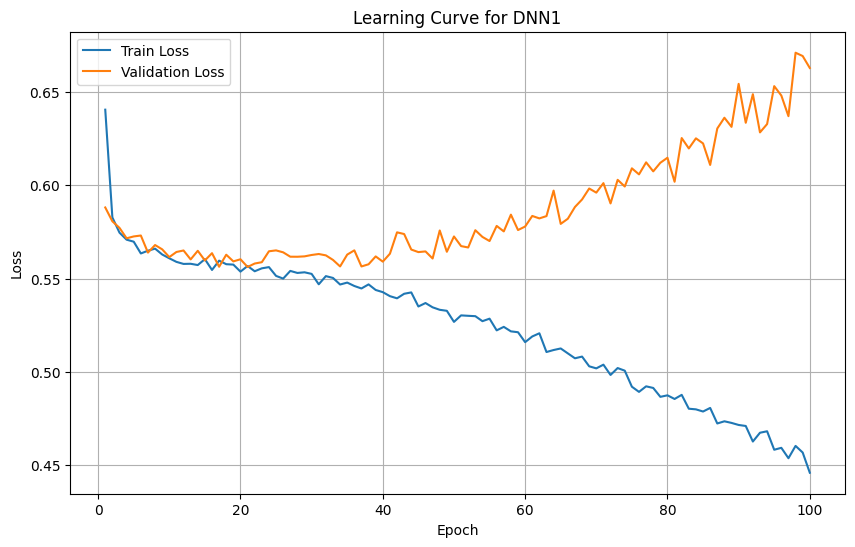

In [19]:
best_params=study.best_params
model = DNN_12(input_dim=X_train_tensor.shape[1],
              dropout1=best_params["dropout1"],
              dropout2=best_params["dropout2"],).to(device)
# 最適化と訓練を実行
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"],weight_decay=best_params["weight_decay"])
criterion = nn.BCELoss()

num_epochs=100
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch.squeeze())
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    if val_loader is not None:
        model.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val.squeeze())
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        model.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN1')
plt.legend()
plt.grid()
plt.show()

Accuracy: 59.79%
Precision: 0.4767
Recall: 0.4218
F1 Score: 0.4476
Matthews Correlation Coefficient: 0.1340
Specificity: 0.7087


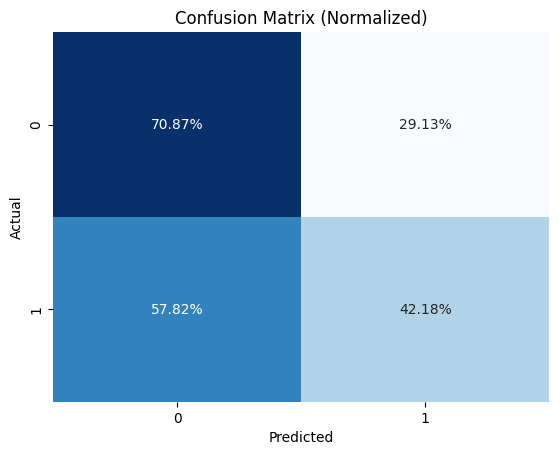

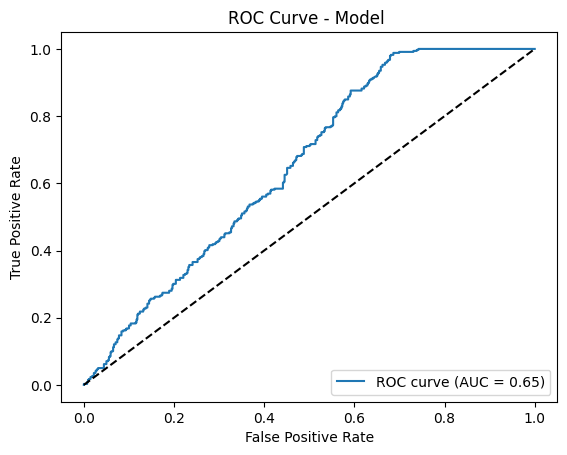

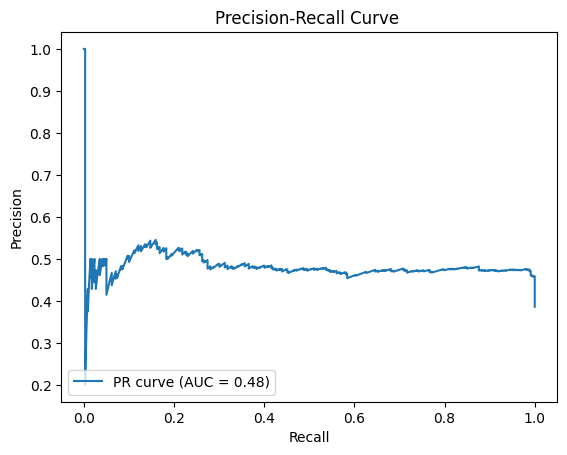

In [20]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs >0.49).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

# 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)  
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # 混同行列（割合表示）
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Normalized)")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model ')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall曲線
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ')
    plt.legend(loc="lower left")
    plt.show()    

In [21]:
# モデルと構造を保存
torch.save(model.state_dict(), '../../saved_model/DNN_12.pth')

